In [11]:
import cobra
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [16]:
def inf_to_100000(model):
    for r in model.reactions:
        if np.isinf(r.lower_bound):
            r.lower_bound = -100000
        if np.isinf(r.upper_bound):
            r.upper_bound = 100000
    return model

def print_summary(model, solution):
    # Print uptake
    for r in model.exchanges:
        flux = solution[r.id]
        if  flux >1e-3:
            print(r.id, r.name,flux, r.bounds)
        elif flux < -1e-3:
            print(r.id, r.name,flux, r.bounds)
    #print("## Demands ##")
    #for r in model.demands:
    #    print(r.id, solution[r.id])

    print("Growth: ", solution['r_2111'])
    print("Prot pool exchange: ", solution['prot_pool_exchange'])

In [17]:
model = cobra.io.read_sbml_model('models/yeast/ecYeastGEM_batch_8_3_4.xml')
model = inf_to_100000(model)

In [18]:
# Data on glucose uptake https://ami-journals.onlinelibrary.wiley.com/doi/10.1111/1751-7915.13995
init_glucose_conc = 16 #g/L
glucose_mw = 180.156 #g/mol
conc_gluc_mM = (init_glucose_conc/glucose_mw)*1e3
km_glc = 0.28 #mmol l−1
vmax_glc = 10 #mmol gDW−1

r_glc = vmax_glc * conc_gluc_mM / (conc_gluc_mM + km_glc)
print(r_glc)

9.968571784677293


## Note
As also stated in https://ami-journals.onlinelibrary.wiley.com/doi/10.1111/1751-7915.13995 glucose uptake is not constrained by km (i.e. vmax = 10)


In [19]:
model.reactions.get_by_id('r_1714_REV').upper_bound = 10


In [20]:
for r in model.reactions:
    if r.objective_coefficient ==1:
        print(r.id, r.name)

r_2111 growth


In [21]:
solution = model.optimize()
print_summary(model, solution)


r_1634 acetate exchange 3.1280052022880684 (0.0, 100000)
r_1672 carbon dioxide exchange 14.497367670034173 (0.0, 100000)
r_1761 ethanol exchange 9.481321215226956 (0.0, 100000)
r_1793 formate exchange 0.015479323997860745 (0.0, 100000)
r_2033 pyruvate exchange 1.8211915849188183 (0.0, 100000)
r_2100 water exchange 13.349446934783707 (0.0, 100000)
r_1654_REV ammonium exchange (reversible) 2.47436986658537 (0.0, 100000)
r_1714_REV D-glucose exchange (reversible) 10.0 (0.0, 10)
r_1832_REV H+ exchange (reversible) 4.105543023388592 (0.0, 100000)
r_1992_REV oxygen exchange (reversible) 5.235025465027337 (0.0, 100000)
r_2005_REV phosphate exchange (reversible) 0.09876531190371217 (0.0, 100000)
r_2020_REV potassium exchange (reversible) 0.0013110509863839377 (0.0, 100000)
r_2049_REV sodium exchange (reversible) 0.0014338491503978598 (0.0, 100000)
r_2060_REV sulphate exchange (reversible) 0.033062502733072076 (0.0, 100000)
Growth:  0.36117107062918397
Prot pool exchange:  0.103720024310123


# FVA

In [22]:
dfv2 = cobra.flux_analysis.flux_variability_analysis(model, reaction_list = model.exchanges, fraction_of_optimum = 0.99)

In [23]:
dfv2 = dfv2.loc[dfv2.abs().max(1) > 1e-4, :]

In [24]:
names = []
for idx in dfv2.index:
    names.append(model.reactions.get_by_id(idx).name)
dfv2["Reaction name"] = names

In [25]:
dfv2.to_csv('models/yeast/dfv99.csv', float_format='%.3f')#, sep = ";")

## Check shadow prices
Check whether there is a correlation between shadow prices and peak metabolite concentrations

In [26]:
import scipy.stats as st

In [99]:
model = cobra.io.read_sbml_model('models/yeast/ecYeastGEM_batch_8_3_4.xml')
model = inf_to_100000(model)

In [100]:
# Set carbon uptake
glucose_uptake = 10
model.reactions.get_by_id('r_1714_REV').upper_bound = glucose_uptake
#model.reactions.get_by_id('r_1714').lower_bound = -9

In [101]:
solution = model.optimize()
print_summary(model, solution)

r_1634 acetate exchange 3.1280052022880684 (0.0, 100000)
r_1672 carbon dioxide exchange 14.497367670034173 (0.0, 100000)
r_1761 ethanol exchange 9.481321215226956 (0.0, 100000)
r_1793 formate exchange 0.015479323997860745 (0.0, 100000)
r_2033 pyruvate exchange 1.8211915849188183 (0.0, 100000)
r_2100 water exchange 13.349446934783707 (0.0, 100000)
r_1654_REV ammonium exchange (reversible) 2.47436986658537 (0.0, 100000)
r_1714_REV D-glucose exchange (reversible) 10.0 (0.0, 10)
r_1832_REV H+ exchange (reversible) 4.105543023388592 (0.0, 100000)
r_1992_REV oxygen exchange (reversible) 5.235025465027337 (0.0, 100000)
r_2005_REV phosphate exchange (reversible) 0.09876531190371217 (0.0, 100000)
r_2020_REV potassium exchange (reversible) 0.0013110509863839377 (0.0, 100000)
r_2049_REV sodium exchange (reversible) 0.0014338491503978598 (0.0, 100000)
r_2060_REV sulphate exchange (reversible) 0.033062502733072076 (0.0, 100000)
Growth:  0.36117107062918397
Prot pool exchange:  0.103720024310123


In [104]:
# Read measurements
measurements = pd.read_csv('yeast_measurements.csv')
measurements.drop(columns = ["Note"], inplace = True)
# Read metabolite mapping
mapping_df = pd.read_csv('id_mapping.csv')

In [105]:
met_id_key = "Yeast metabolite"
name_to_met_id = mapping_df.loc[:, ["Metabolite name", met_id_key]].set_index("Metabolite name").to_dict()[met_id_key]

In [106]:
solution = model.optimize()
shadow_prices = []
for i, row in measurements.iterrows():
    key = name_to_met_id[row["Metabolite name"]]
    try:
        keys = key.split(",")
    except:
        print(key)
        shadow_prices.append(np.nan)
        continue
    values = []
    for key in keys:
        met_id = "{0}[c]".format(key.strip())
        values.append(solution.shadow_prices[met_id])
    shadow_prices.append(max(values))

nan
nan
nan


In [107]:
df = measurements.copy()
df["Shadow price"] = np.abs(shadow_prices)
df = df.loc[~df.isna().any(axis = 1), :]
df = df.loc[df.Value != 0, :]
df = df.loc[df["Shadow price"] != 0, :]


In [108]:
df

,Metabolite name,Value,Uncertainty,Shadow price
0,Glucose-6-phosphate,17.65,0.53,0.008056
1,Fructose-6-phosphate,29.29,0.60,0.008135
2,"Fructose-1,6-bisphosphate",34.21,0.72,0.012011
3,Dihydroxyacetonephosphate,50.40,1.74,0.006537
4,Glyceraldehyde-3-phosphate,15.04,0.24,0.006540
5,2/3-phosphoglycerate,19.45,1.55,0.003843
6,Phosphoenolpyruvate,20.43,0.28,0.004048
9,Ribose-5-phosphate,10.29,0.22,0.009358
10,Ribu-/Xylulose-5-phosphate,3.69,0.04,0.006785
11,Erythrose-4-phosphate,1.31,0.21,0.008668


In [109]:
corrp = st.spearmanr(np.log10(df["Value"]), np.log10(df["Shadow price"]))
print(corrp[0], corrp[1])

-0.07807917888563048 0.6710121625864036


In [110]:
corrp = st.pearsonr(np.log10(df["Value"]), np.log10(df["Shadow price"]))
print(corrp[0], corrp[1])

-0.06626517484541242 0.7185965948263843


In [112]:
df["log10(shadow price)"] = np.log10(df["Shadow price"])
df["log10(metabolite concentration)"] = np.log10(df.Value)

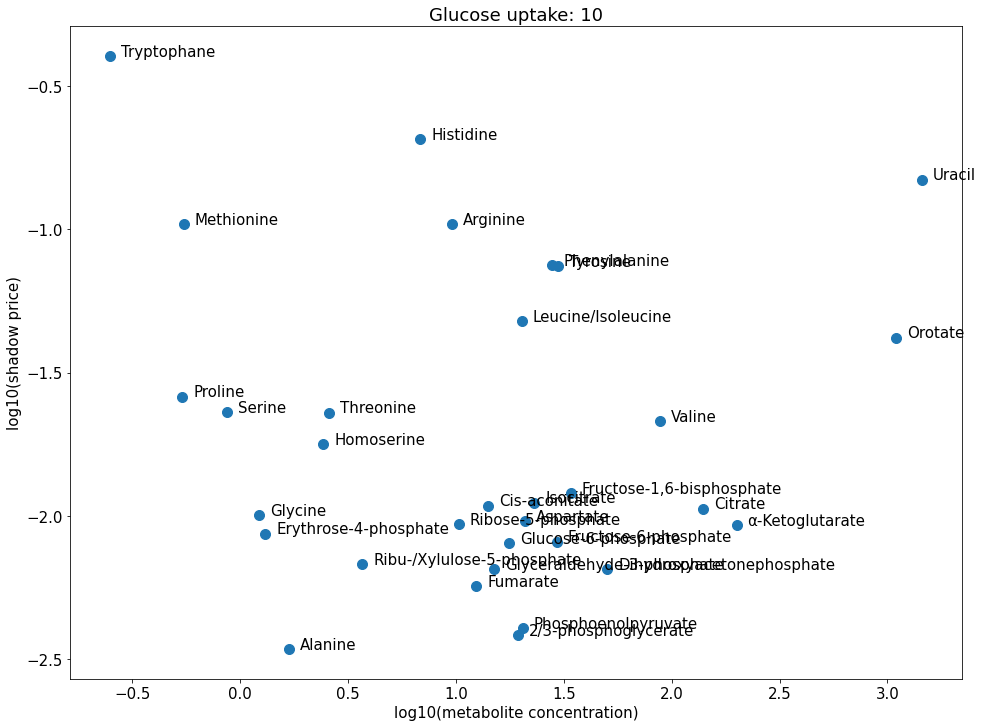

In [113]:
plt.rcParams.update({'font.size': 15})
ax = df.plot.scatter(x = "log10(metabolite concentration)", y = "log10(shadow price)", figsize = (16, 12),
                    fontsize = 15, s = 100)
# Annotate each data point
for i, txt in enumerate(df["Metabolite name"]):
    ax.annotate(txt, (df["log10(metabolite concentration)"].iat[i]+0.05, df["log10(shadow price)"].iat[i]))

plt.title("Glucose uptake: {0}".format(glucose_uptake))
#ax.plot(df["log10(metabolite concentration)"], trendline_fun(df["log10(metabolite concentration)"]))
ax.annotate("Pearson corr: {0:.2f}, p-value: {1:.3f}".format(corrp[0], corrp[1]), (-2, -1.55), fontsize = 15, c = 'r')
#ax.annotate("Pearson corr: {0:.2f}, p-value: {1:.3f}".format(corrp[0], corrp[1]), (-1.5, -2.5), fontsize = 15, c = 'r')
plt.savefig('results/yeast/shadow_price_vs_met_conc_glc{0}.svg'.format(glucose_uptake))
plt.savefig('results/yeast/shadow_price_vs_met_conc_glc{0}.png'.format(glucose_uptake))

In [ ]:
solution_0 = model.optimize()
print_summary(model, solution)
met_id = 's_0680[c]'
print(solution.shadow_prices[met_id])

with model:
    m = model.metabolites.get_by_id(met_id)#s_0680 ethanol
    #r_demand = model.add_boundary(m, type="demand")
    #r_demand.bounds = (10,10)
    ethanol_production = solution.fluxes["r_1761"]
    model.reactions.r_1761.bounds = (ethanol_production+1,ethanol_production+1)
    solution = model.optimize()
    print_summary(model, solution)
    print(model.demands)
shadow_price_ethanol = solution_0['r_2111']- solution['r_2111']

In [273]:
solution_0 = model.optimize()
growth_rate = solution_0['r_2111']
manual_shadow_prices = {}
for i, row in measurements.iterrows():
    key = name_to_met_id[row["Metabolite name"]]
    try:
        keys = key.split(",")
    except:
        print(key)
        shadow_prices.append(np.nan)
        continue
    values = []
    for key in keys:
        with model:
            met_id = "{0}[c]".format(key.strip())
            m = model.metabolites.get_by_id(met_id)
            r_demand = model.add_boundary(m, type="demand")
            r_demand.bounds = (0.1,0.1)
            solution = model.optimize()
            values.append((growth_rate - solution['r_2111'])*10)
    manual_shadow_prices[row["Metabolite name"]] = min(values)
    print(m.id, min(values), solution_0.shadow_prices[met_id])

s_0568[c] 0.008056488170088416 -0.008056488170054334
s_0557[c] 0.008134725790612252 -0.008134725790575848
s_0555[c] 0.01264485424877948 -0.012644854248741382
s_0629[c] 0.00653694062810517 -0.006536940628107867
s_0764[c] 0.0065396450138593964 -0.006539645013858835
s_0260[c] 0.0038429488647995225 -0.003842948864795603
s_1360[c] 0.004048379758957998 -0.004048379758955457
s_1399[c] 0.0 -0.0
s_0340[c] 0.008031969305279385 -0.008031969305275615
s_1408[c] 0.009358325039156568 -0.009358325039163359
s_0581[c] 0.006784868970906577 -0.006941251474536198
s_0551[c] 0.008668293099051705 -0.008668293099050766
s_1427[c] 0.010695105269054594 -0.010695105268993005
s_0373[c] -0.004354160824951991 0.00435416082494019
s_0522[c] 0.010606231642334984 -0.010606231642352283
s_0516[c] 0.010866643277773758 -0.010866643277792307
s_0940[c] 0.0111270549132092 -0.01112705491323233
s_0180[c] 0.00929216562432611 -0.009292165624349836
s_0725[c] 0.005702298573190823 -0.005702298573217975
s_0066[c] 0.005747195658510895 -

's_1550'